In [ ]:
# Upload Dataset
import pandas as pd

df = pd.read_csv("https://drive.google.com/uc?export=download&id=1cEt1aeFgeTDkCb9Calb5ib2KQALf0JeE")

Sklearn Model

Number of classes detected: 7

✅ Overall Round Prediction Accuracy: 0.543



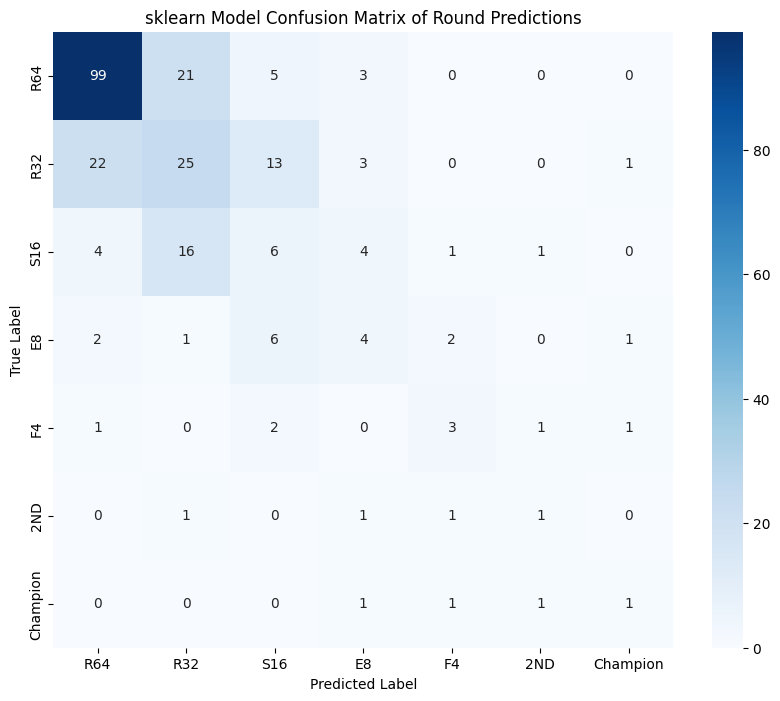

<ipython-input-7-8b1b7942a87a>:266: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracy_per_round, palette='crest')


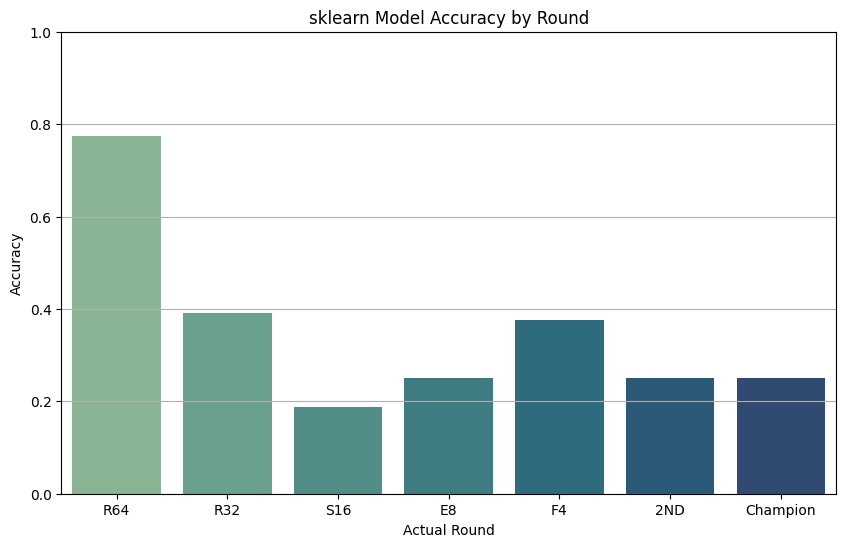


--- 2014 Bracket Predictions ---
Michigan St. (E): Rank 1 → F4
Louisville (M): Rank 1 → 2ND
Arizona (W): Rank 1 → F4
Florida (S): Rank 1 → Champion
UCLA (S): Rank 2 → E8
Creighton (W): Rank 2 → E8
Michigan (M): Rank 2 → E8
Connecticut (E): Rank 2 → E8
Virginia (E): Rank 3 → S16
Duke (M): Rank 3 → S16
Gonzaga (W): Rank 3 → S16
Pittsburgh (S): Rank 3 → S16
Dayton (S): Rank 4 → S16
Wisconsin (W): Rank 4 → S16
Wichita St. (M): Rank 4 → S16
Iowa St. (E): Rank 4 → S16
Villanova (E): Rank 5 → R32
Tennessee (M): Rank 5 → R32
Oklahoma (W): Rank 5 → R32
Ohio St. (S): Rank 5 → R32
Syracuse (S): Rank 6 → R32
Baylor (W): Rank 6 → R32
Kentucky (M): Rank 6 → R32
Providence (E): Rank 6 → R32
Memphis (E): Rank 7 → R32
North Carolina St. (M): Rank 7 → R32
San Diego St. (W): Rank 7 → R32
VCU (S): Rank 7 → R32
Stanford (S): Rank 8 → R32
Oregon (W): Rank 8 → R32
Mercer (M): Rank 8 → R32
Saint Joseph's (E): Rank 8 → R32
American (W): Rank 9 → R64
Kansas (S): Rank 9 → R64
Cincinnati (E): Rank 9 → R64
Saint 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1cEt1aeFgeTDkCb9Calb5ib2KQALf0JeE")

# Drop bad or missing POSTSEASON values
df = df[df['POSTSEASON'] != "NA"]
df = df.dropna(subset=['POSTSEASON'])

# Convert POSTSEASON to numeric round scores
round_mapping = {
    'R64': 1, 'R32': 2, 'S16': 3,
    'E8': 4, 'F4': 5, '2ND': 6, 'Champions': 7
}
df['round_numeric'] = df['POSTSEASON'].map(round_mapping)
df = df.dropna(subset=['round_numeric'])

# Convert SEED to numeric
df['SEED'] = pd.to_numeric(df['SEED'], errors='coerce')
df = df.dropna(subset=['SEED'])

# Split by year
train_years = [2013, 2015, 2016, 2018, 2019, 2021, 2022, 2024]
test_years = [2014, 2017, 2023, 2025]
train_df = df[df['YEAR'].isin(train_years)].copy()
test_df = df[df['YEAR'].isin(test_years)].copy()

# Features
drop_cols = ['POSTSEASON', 'TEAM', 'CONF', 'YEAR', 'REGION', 'round_numeric']
X_train = train_df.drop(columns=drop_cols).select_dtypes(include='number')
y_train = train_df['round_numeric']

X_test = test_df.drop(columns=drop_cols).select_dtypes(include='number')
y_test = test_df['round_numeric']

# Match columns
X_test = X_test[X_train.columns]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Manually calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {cls: class_weights[i] for i, cls in enumerate(np.unique(y_train))}

# Train a classification model with MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Check the number of classes and make sure we handle it correctly
num_classes = len(np.unique(y_train))
print(f"Number of classes detected: {num_classes}")

# Predict probabilities for all classes
predicted_probabilities = model.predict_proba(X_test_scaled)

# Ensure we use the correct index for "Champion" based on the number of classes
champion_index = 6 if num_classes > 6 else num_classes - 1

# Assign the score based on the Champion's class probability
test_df = test_df.copy()
test_df['score'] = predicted_probabilities[:, champion_index]

# Rank teams within each REGION + YEAR
test_df = test_df.sort_values(['YEAR', 'REGION', 'score'], ascending=[True, True, False])
test_df['regional_rank'] = test_df.groupby(['YEAR', 'REGION']).cumcount() + 1

# Assign predicted POSTSEASON round based on regional rank
def assign_region_round(rank):
    if rank == 1:
        return 'F4'
    elif rank == 2:
        return 'E8'
    elif 3 <= rank <= 4:
        return 'S16'
    elif 5 <= rank <= 8:
        return 'R32'
    elif 9 <= rank <= 16:
        return 'R64'
    else:
        return None

test_df['predicted_round'] = test_df['regional_rank'].apply(assign_region_round)

# Choose 1 champion and 1 runner-up from the 4 Final Four teams
final_four = test_df[test_df['predicted_round'] == 'F4'].copy()
final_four = final_four.sort_values(['YEAR', 'score'], ascending=[True, False])

# Mark Champion and Runner-Up
champions = final_four.groupby('YEAR').head(1)
runners_up = final_four.groupby('YEAR').nth(1)

# Final labels
test_df['final_prediction'] = test_df['predicted_round']
test_df.loc[champions.index, 'final_prediction'] = 'Champion'
test_df.loc[runners_up.index, 'final_prediction'] = '2ND'

# Accuracy Evaluation
compare_df = test_df.copy()
compare_df['true_round'] = compare_df['POSTSEASON']
compare_df['predicted_round'] = compare_df['final_prediction']
compare_df = compare_df.dropna(subset=['true_round', 'predicted_round'])

# Fix for classification report to handle Champion correctly
compare_df['true_round'] = compare_df['true_round'].replace({'Champions': 'Champion'})

# Report overall accuracy and classification details
acc = accuracy_score(compare_df['true_round'], compare_df['predicted_round'])
print(f"\n✅ Overall Round Prediction Accuracy: {acc:.3f}\n")

# --- Confusion Matrix ---
labels = ['R64', 'R32', 'S16', 'E8', 'F4', '2ND', 'Champion']
cm = confusion_matrix(compare_df['true_round'], compare_df['predicted_round'], labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("sklearn Model Confusion Matrix of Round Predictions")
plt.show()

# --- Accuracy by Round (Bar Graph) ---
accuracy_per_round = []
for rnd in labels:
    round_data = compare_df[compare_df['true_round'] == rnd]
    if len(round_data) > 0:
        correct = (round_data['true_round'] == round_data['predicted_round']).sum()
        acc = correct / len(round_data)
        accuracy_per_round.append(acc)
    else:
        accuracy_per_round.append(0)

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=accuracy_per_round, palette='crest')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Actual Round")
plt.title("sklearn Model Accuracy by Round")
plt.grid(axis='y')
plt.show()

# Show predictions
for year in sorted(test_df['YEAR'].unique()):
    print(f"\n--- {year} Bracket Predictions ---")
    year_df = test_df[test_df['YEAR'] == year].sort_values('regional_rank')
    for _, row in year_df.iterrows():
        print(f"{row['TEAM']} ({row['REGION']}): Rank {row['regional_rank']} → {row['final_prediction']}")


Baseline Models


=== Model Accuracy Comparison ===
Random Forest: 0.59
Logistic Regression: 0.523
KNN (k=5): 0.504

=== Baseline Model Accuracy Comparison ===


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Random Forest: 0.59
Logistic Regression: 0.523
KNN (k=5): 0.504


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


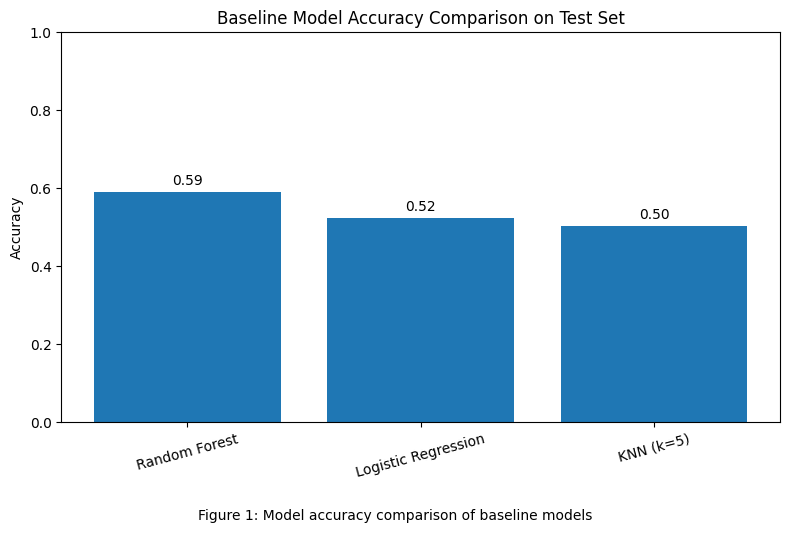

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1cEt1aeFgeTDkCb9Calb5ib2KQALf0JeE")

# Drop rows without valid postseason results
df = df.dropna(subset=['POSTSEASON'])
df = df[df['POSTSEASON'] != "NA"]

# Split years
train_years = [2013, 2015, 2016, 2018, 2019, 2021, 2022, 2024]
test_years = [2014, 2017, 2023, 2025]
train_df = df[df['YEAR'].isin(train_years)].copy()
test_df = df[df['YEAR'].isin(test_years)].copy()

# Map rounds to numbers
round_mapping = {'R64': 1, 'R32': 2, 'S16': 3, 'E8': 4, 'F4': 5, '2ND': 6, 'Champions': 7}
train_df['round_numeric'] = train_df['POSTSEASON'].map(round_mapping)
test_df['round_numeric'] = test_df['POSTSEASON'].map(round_mapping)

# Drop rows with missing targets
train_df = train_df.dropna(subset=['round_numeric'])
test_df = test_df.dropna(subset=['round_numeric'])

# Feature selection
def prepare_features(df_subset):
    X = df_subset.drop(columns=['SEED', 'POSTSEASON', 'round_numeric', 'TEAM'])
    X = X.select_dtypes(include='number')
    X['REGION'] = df_subset['REGION']
    return X

X_train = prepare_features(train_df)
X_test = prepare_features(test_df)
y_train = train_df['round_numeric']
y_test = test_df['round_numeric']

# Encode region
le = LabelEncoder()
X_train['REGION'] = le.fit_transform(X_train['REGION'])
X_test['REGION'] = le.transform(X_test['REGION'])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, multi_class='multinomial'),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
}

print("\n=== Model Accuracy Comparison ===")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: {round(acc, 3)}")


import matplotlib.pyplot as plt

# Store results
model_names = []
accuracies = []

print("\n=== Baseline Model Accuracy Comparison ===")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    model_names.append(name)
    accuracies.append(acc)
    print(f"{name}: {round(acc, 3)}")

# Plot Accuracy Comparison
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies)
plt.title("Baseline Model Accuracy Comparison on Test Set")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Add accuracy labels on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{acc:.2f}", ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=15)
plt.figtext(0.5, -0.05, "Figure 1: Model accuracy comparison of baseline models",
            wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.show()


Tensorflow Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<ipython-input-2-31ea5dfadc4c>:190: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_round = results.groupby('true_round').apply(lambda x: (x['true'] == x['pred']).mean()).reset_index()
<ipython-input-2-31ea5dfadc4c>:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=accuracy_by_round, x='Round', y='Accuracy', palette='coolwarm')


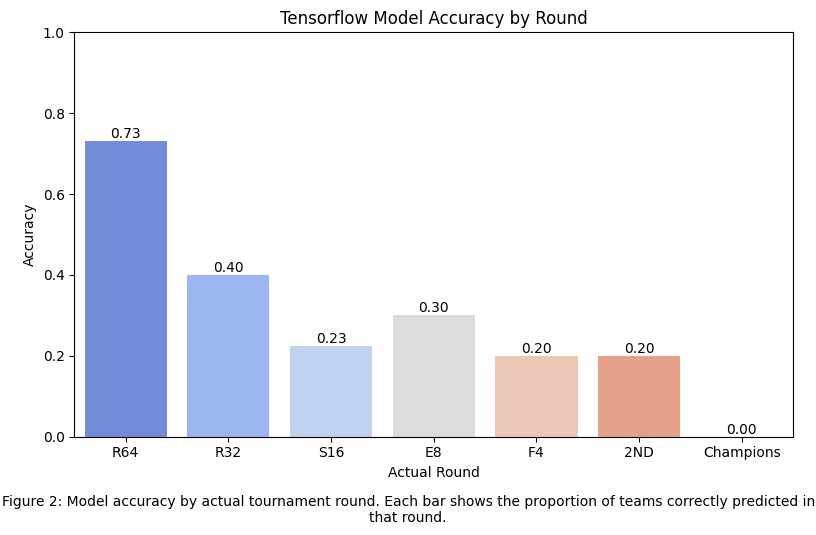


TensorFlow Neural Network Accuracy
Accuracy: 0.52


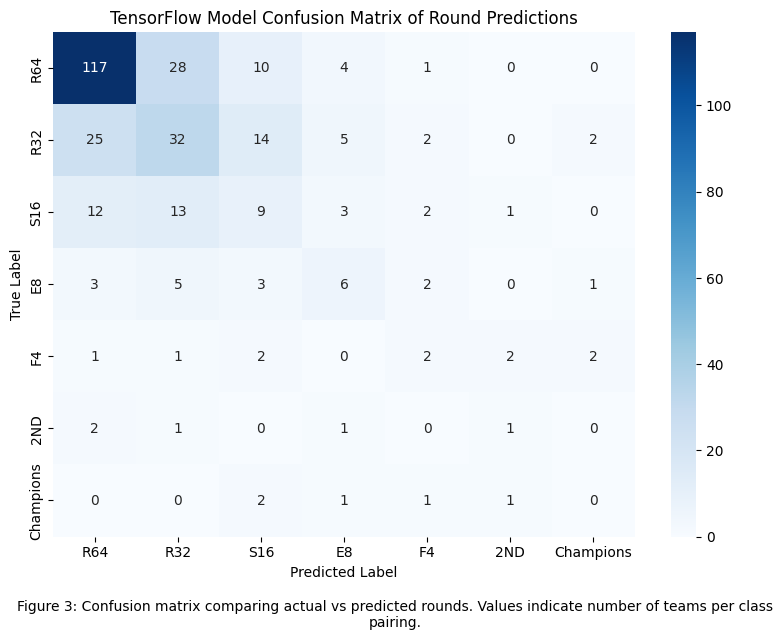

In [2]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Set seeds
seed_val = 42
np.random.seed(seed_val)
random.seed(seed_val)
tf.random.set_seed(seed_val)

# Load and clean data
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1cEt1aeFgeTDkCb9Calb5ib2KQALf0JeE")
df = df.dropna(subset=['POSTSEASON'])
df = df[df['POSTSEASON'] != "NA"]

# Set splits
train_years_full = [2013, 2016, 2018, 2019, 2021, 2022, 2024]
test_years = [2014, 2015, 2017, 2023, 2025]
val_years = [2018]
train_years = [y for y in train_years_full if y not in val_years]

train_df = df[df['YEAR'].isin(train_years)].copy()
val_df = df[df['YEAR'].isin(val_years)].copy()
test_df = df[df['YEAR'].isin(test_years)].copy()

# Map rounds
round_mapping = {'R64': 1, 'R32': 2, 'S16': 3, 'E8': 4, 'F4': 5, '2ND': 6, 'Champions': 7}
train_df['round_numeric'] = train_df['POSTSEASON'].map(round_mapping)
val_df['round_numeric'] = val_df['POSTSEASON'].map(round_mapping)
test_df['round_numeric'] = test_df['POSTSEASON'].map(round_mapping)

train_df.dropna(subset=['round_numeric'], inplace=True)
val_df.dropna(subset=['round_numeric'], inplace=True)
test_df.dropna(subset=['round_numeric'], inplace=True)

# Oversampling
oversample_rounds = ['2ND', 'Champions','F4','E8']
duplication_factor = {'2ND': 15, 'Champions': 15, 'F4':8, 'E8':4}
for rnd in oversample_rounds:
    dup_df = train_df[train_df['POSTSEASON'] == rnd]
    train_df = pd.concat([train_df] + [dup_df] * duplication_factor[rnd], ignore_index=True)
train_df = train_df.sample(frac=1, random_state=seed_val).reset_index(drop=True)

# Feature prep
def prepare_features(df_subset):
    X = df_subset.drop(columns=['POSTSEASON', 'round_numeric', 'TEAM'])
    X = X.select_dtypes(include='number')
    X['REGION'] = df_subset['REGION']
    return X

X_train = prepare_features(train_df)
X_val = prepare_features(val_df)
X_test = prepare_features(test_df)

# Encode region
le = LabelEncoder()
X_train['REGION'] = le.fit_transform(X_train['REGION'])
X_val['REGION'] = le.transform(X_val['REGION'])
X_test['REGION'] = le.transform(X_test['REGION'])

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Targets
y_train_raw = train_df['round_numeric'] - 1
y_val_raw = val_df['round_numeric'] - 1
y_test_raw = test_df['round_numeric'] - 1
y_train_cat = to_categorical(y_train_raw)
y_val_cat = to_categorical(y_val_raw)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_raw), y=y_train_raw)
class_weight_dict = dict(enumerate(class_weights))

# Model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fitting Model
model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=0
)

# Predict
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)


y_pred_prob = model.predict(X_test_scaled)

# Enforce fixed number of teams per round per year
test_df_copy = test_df.copy()
test_df_copy['champ_prob'] = y_pred_prob[:, 6]  # Probability of being champion (class 6 in 0-based)

# Prepare new round assignments
test_df_copy = test_df.copy()
test_df_copy['champ_prob'] = y_pred_prob[:, 6]  # Probability of being champion (class 6 in 0-based)

final_preds = []

# Setting maximums for assigning rounds
for year in sorted(test_df_copy['YEAR'].unique()):
    year_df = test_df_copy[test_df_copy['YEAR'] == year].copy()

    # Sort by predicted championship probability
    year_df = year_df.sort_values(by='champ_prob', ascending=False).reset_index(drop=True)

    # Exact round sizes to assign (adds to 64)
    round_sizes = {
        7: 1,   # Champion
        6: 1,   # 2ND
        5: 2,   # F4
        4: 4,   # E8
        3: 8,   # S16
        2: 16,  # R32
        1: 32   # R64
    }

    # Assign based on slice ranges
    idx = 0
    assigned = pd.Series([0]*len(year_df))
    for round_num, size in round_sizes.items():
        assigned.iloc[idx:idx + size] = round_num
        idx += size

    # Ensure only 64 teams total are used
    year_df = year_df.iloc[:64]
    year_df['predicted_round'] = assigned.iloc[:64].values
    final_preds.append(year_df)

# Combine all years
test_df_copy = pd.concat(final_preds, ignore_index=True)

# print("\nSanity Check: Actual 2ND per year")
# for year in sorted(test_df_copy['YEAR'].unique()):
#     actual_2nd = test_df[(test_df['YEAR'] == year) & (test_df['round_numeric'] == 6)]
#     print(f"{year}: {actual_2nd['TEAM'].tolist()}")

# print("\nSanity Check: Predicted 2ND per year")
# for year in sorted(test_df_copy['YEAR'].unique()):
#     pred_2nd = test_df_copy[(test_df_copy['YEAR'] == year) & (test_df_copy['predicted_round'] == 6)]
#     print(f"{year}: {pred_2nd['TEAM'].tolist()}")

# print("\nSanity Check: Actual Champion per year")
# for year in sorted(test_df_copy['YEAR'].unique()):
#     actual_1nd = test_df[(test_df['YEAR'] == year) & (test_df['round_numeric'] == 7)]
#     print(f"{year}: {actual_1nd['TEAM'].tolist()}")

# print("\nSanity Check: Predicted Champion per year")
# for year in sorted(test_df_copy['YEAR'].unique()):
#     pred_1nd = test_df_copy[(test_df_copy['YEAR'] == year) & (test_df_copy['predicted_round'] == 7)]
#     print(f"{year}: {pred_1nd['TEAM'].tolist()}")

# Align ground truth to filtered predictions
y_true_filtered = test_df_copy['round_numeric'].values - 1
y_pred_filtered = test_df_copy['predicted_round'].values - 1

# Getting accuracies
results = pd.DataFrame({'true': y_true_filtered, 'pred': y_pred_filtered})
label_map = {0: 'R64', 1: 'R32', 2: 'S16', 3: 'E8', 4: 'F4', 5: '2ND', 6: 'Champions'}
results['true_round'] = results['true'].map(label_map)
accuracy_by_round = results.groupby('true_round').apply(lambda x: (x['true'] == x['pred']).mean()).reset_index()
accuracy_by_round.columns = ['Round', 'Accuracy']
accuracy_by_round = accuracy_by_round.set_index('Round').reindex(list(label_map.values()), fill_value=0).reset_index()

# Plotting accuracy by round
plt.figure(figsize=(8, 5))
barplot = sns.barplot(data=accuracy_by_round, x='Round', y='Accuracy', palette='coolwarm')
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=10, color='black')
plt.ylim(0, 1)
plt.title("Tensorflow Model Accuracy by Round")
plt.figtext(0.5, -0.05, "Figure 2: Model accuracy by actual tournament round. Each bar shows the proportion of teams correctly predicted in that round.",
            wrap=True, horizontalalignment='center', fontsize=10)
plt.ylabel("Accuracy")
plt.xlabel("Actual Round")
plt.tight_layout()
plt.show()

print("\nTensorFlow Neural Network Accuracy")
print("Accuracy:", round(accuracy_score(results['true'], results['pred']), 2))

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(results['true'], results['pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("TensorFlow Model Confusion Matrix of Round Predictions")
plt.figtext(0.5, -0.05, "Figure 3: Confusion matrix comparing actual vs predicted rounds. Values indicate number of teams per class pairing.",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()

plt.show()

Completely Random Predictions Model

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://drive.google.com/uc?export=download&id=1cEt1aeFgeTDkCb9Calb5ib2KQALf0JeE")

df = df.dropna(subset=['POSTSEASON'])
df = df[df['POSTSEASON'] != "NA"]

round_mapping = {
    'R64': 1, 'R32': 2, 'S16': 3,
    'E8': 4, 'F4': 5, '2ND': 6, 'Champions': 7
}
df['round_numeric'] = df['POSTSEASON'].map(round_mapping)
df = df.dropna(subset=['round_numeric'])

train_years = [2013, 2015, 2016, 2018, 2019, 2021, 2022, 2024]
test_years = [2014, 2017, 2023, 2025]
test_df = df[df['YEAR'].isin(test_years)].copy()

possible_rounds = [1, 2, 3, 4, 5, 6, 7]
random_predictions = np.random.choice(possible_rounds, size=len(test_df))

true_labels = test_df['round_numeric'].astype(int).values
accuracy = np.mean(random_predictions == true_labels)

print("\n=== 100% Random Baseline Accuracy ===")
print(f"Accuracy: {round(accuracy, 2)}")



=== 100% Random Baseline Accuracy ===
Accuracy: 0.17
